# TDE Candidates
This notebook was originally written by Matt Nicholl.  It has been slightly modified and annotated by Ken Smith for tutorial purposes. It bypasses the Lasair Client code for the time being.  The code demonstrates use of the Lasair API to:
* Grab your token
* Make Queries
* Grab lightcurves

The code also demonstrates how to interact with the TNS API and also the PS1 postage stamp server at MAST.

### Do the imports

In [10]:
import os, requests, json, csv
import sys
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astropy.time import Time
from lasair import LasairError, lasair_client as lasair
import settings

### Large SQL query
See https://lasair-ztf.lsst.ac.uk/schema to see what metadata is available in the Objects table.

In [11]:
# Matt's query
# Get the following:
# objectId,
# TNS information,
# g - r (mean)
# g - r (latest)
# latest g mag
# latest r mag
# latest observation in UTC
# number of good, positive flux detections
# number of good, positive flux detections in the last 14 days
# Is it rising or fading
# sherlock classification
# distance from sherlock host
# brightest g mag point
# brightest r mag point
# nearest possible ps1 host gmag point
# nearest possible ps1 host rmag point
# colour of possible ps1 host
# star/galaxy score of ps1 host
# discovery mjd
# latest mjd
# coordinates

selected = """
objects.objectId, crossmatch_tns.tns_name, crossmatch_tns.type,
    ROUND(objects.maggmean - objects.magrmean, 2) AS g_minus_r_mean,
    ROUND(objects.gmag - objects.rmag, 2) AS g_minus_r_latest,
    objects.gmag AS g,
    objects.rmag AS r,
    FROM_UNIXTIME((objects.jdmax - 1721059.5) * (3600 * 24) - TO_SECONDS('1970-01-01 00:00:00')
       + TO_SECONDS(UTC_TIMESTAMP()) - TO_SECONDS(CURRENT_TIMESTAMP())) AS latest_utc,
    objects.ncandgp AS N_obs,
    objects.ncandgp_14 as N_obs_14_day,
    IF(ABS(objects.gmag - objects.maggmin) < 0.2
            AND objects.gmag <= objects.maggmean
            AND ABS(objects.rmag - objects.magrmin) < 0.2
            AND objects.rmag <= objects.magrmean,
        'rising/peak',
        '') rising,
    IF(objects.gmag > objects.maggmin + 0.2
            OR objects.rmag > objects.magrmin + 0.2,
        'fading',
        '') fading,
    sherlock_classifications.classification AS sherlock,
    ROUND(sherlock_classifications.separationArcsec,
            2) AS offsetArcsec,
    objects.maggmin AS g_max,
    objects.magrmin AS r_max,
    objects.sgmag1 AS g_host,
    objects.srmag1 AS r_host,
    ROUND(objects.sgmag1 - objects.srmag1, 2) as g_minus_r_host,
    objects.sgscore1 AS sg_score,
    ROUND(objects.jdmin - 2400000.5, 1) AS disc_mjd,
    ROUND(objects.jdmax - 2400000.5, 1) AS latest_mjd,
    objects.ramean AS ra,
    objects.decmean AS decl
"""

In [12]:
# Tables to be queried
tables = 'objects, sherlock_classifications, crossmatch_tns'

In [13]:
# Matt's WHERE clause:
# Object is within 1 arcsec of Sherlock designated host
# Number of detections is 3 or more
# Most of the detections are positive flux (and "good" quality)
# Sherlock thinks the object is a nuclear transient or SN
# Mean colour is blue or latest colour is blue
# Object is brighter than 20 in r and g
# Object is not within +/-10 degrees of galactic latitude
# Possible PS1 host mag is red
# Only include ZTF21 objects in the resultset
# Latest observation is within the last 14 days
# Just return the objectIds that have 2 or more postive flux detections in the last 2 weeks
conditions = """
sherlock_classifications.separationArcsec < 1.0
        AND objects.ncand > 2
        AND objects.ncand - objects.ncandgp < 3
        AND sherlock_classifications.classification in ('NT','SN')
        AND (objects.maggmean - objects.magrmean < 0.05
        OR objects.gmag - objects.rmag < 0.05)
        AND (objects.rmag < 20.0
        OR objects.gmag < 20.0)
        AND (objects.glatmean > 10
        OR objects.glatmean < - 10)
        AND objects.sgmag1 - objects.srmag1 > 0
        AND objects.jdmax > JDNOW()-14
        AND objects.objectId like 'ZTF24%'
        group by objects.objectId HAVING N_obs_14_day > 1
        order by objects.jdmax DESC
"""


### Send the query request to the Lasair API
Put in a limit of 10 to reduce the number of results returned

### Grab PS1 Postage Stamps
Get stamps for the objects we just selected. These are stored in /tmp by default.

In [14]:
L = lasair(settings.API_TOKEN)
response = L.query(selected, tables, conditions, limit=10)
objectList = [obj['objectId'] for obj in response]
print('Got %d responses' % len(objectList))

Got 7 responses


In [15]:
# Get PS1 image of field

ps1_url = 'http://ps1images.stsci.edu/cgi-bin/ps1filenames.py?&filters=gri'

cutout_url = 'http://ps1images.stsci.edu/cgi-bin/fitscut.cgi?&filetypes=stack&size=240'

print('Downloading PS1 cutouts...')

for obj in response:
    i = obj['objectId']

    dest_file = '/tmp/' + i + '.jpg'
    obj['cutout'] = dest_file

    if not os.path.exists(dest_file):

        # first step searches for the ps1 images matching target coordinates
        ps1_search_url = ps1_url+'&ra='+str(obj['ra']) + '&dec='+str(obj['decl'])
        print(i,obj['ra'],obj['decl'])
        print(ps1_search_url)
        ps1_im = requests.get(ps1_search_url)
        #print("PS1 im.text = ")
        #print(ps1_im.text)

        # 2019-06-16 KWS Modified this to use a csv and StringIO object and present a dictionary.
        response2 = csv.DictReader(StringIO(ps1_im.text), delimiter=' ', skipinitialspace = True)
        respList = []

        for row in response2:
            respList.append(row)

        ps1_g = respList[0]['filename']
        ps1_r = respList[2]['filename']
        ps1_i = respList[1]['filename']
        #print(ps1_g,ps1_r,ps1_i)

        cutout_search_url = cutout_url + '&blue='+ps1_g + '&green='+ps1_r + '&red='+ps1_i
        cutout_search_url +=  '&ra='+str(obj['ra']) + '&dec='+str(obj['decl'])

        cmd = 'curl -o %s "%s"' % (dest_file, cutout_search_url)
        os.system(cmd)

print('Done.')

Done.


### Get Lightcurves with the Lasair /lightcurves/ API
For each object we returned go back to Lasair and get the full lightcuve. This can't be done in a single query anymore because the detections ("candidates") are currently not stored in the database.

Here is a way to handle lightcurves without the use of `pandas` instead only using native python constructs: lists and dictionaries.

In [16]:
lightcurves = []
for obj in response:
    lightcurves.append(
        L.object(obj['objectId'], lasair_added=False)
    )

lcsDict = {}
for lc in lightcurves:
    lcsDict[lc['objectId']] = {'candidates': lc['candidates']}

### Plot the lightcurves and stamps

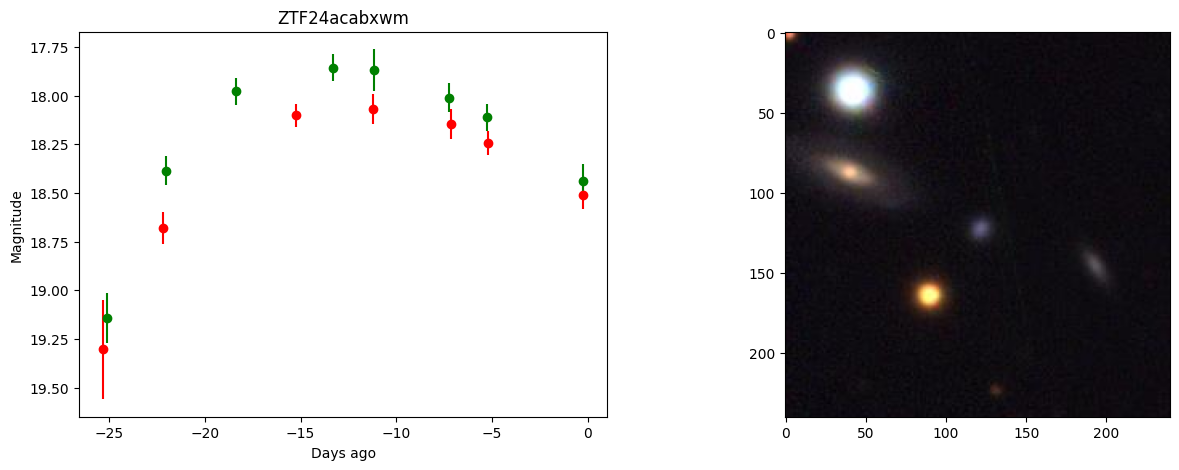

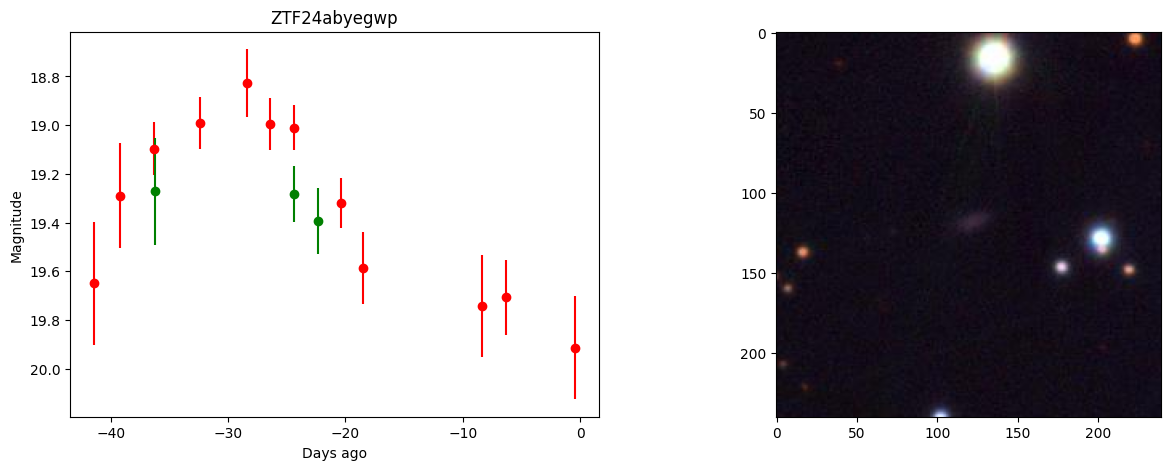

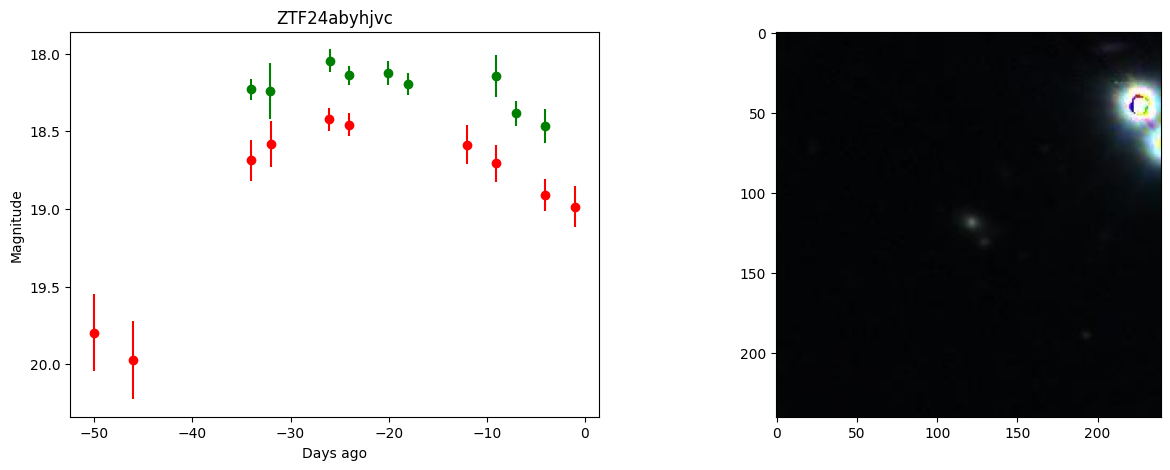

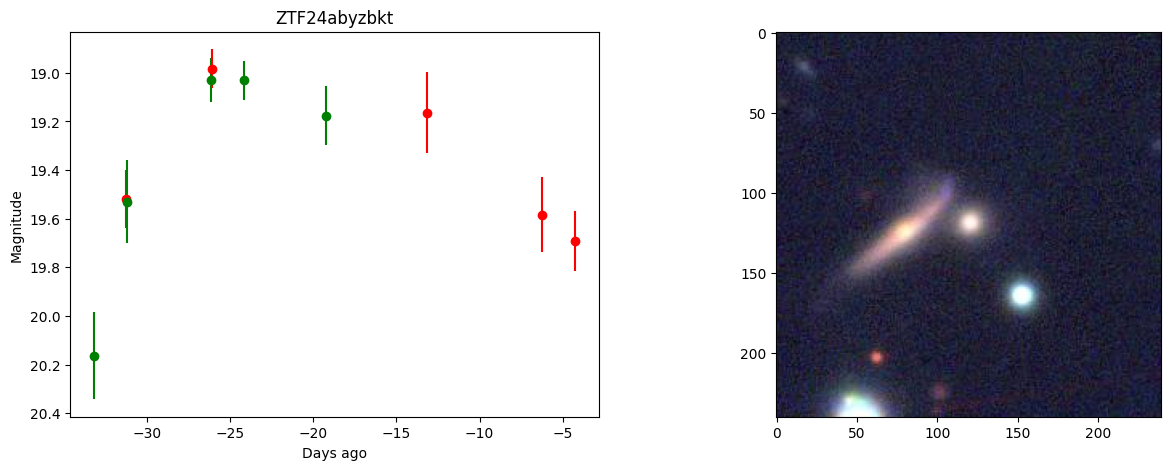

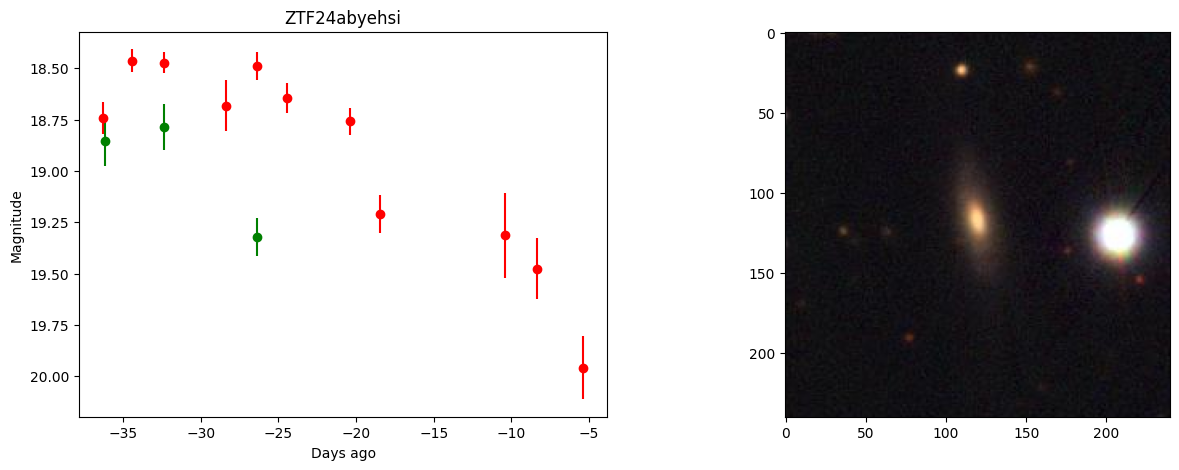

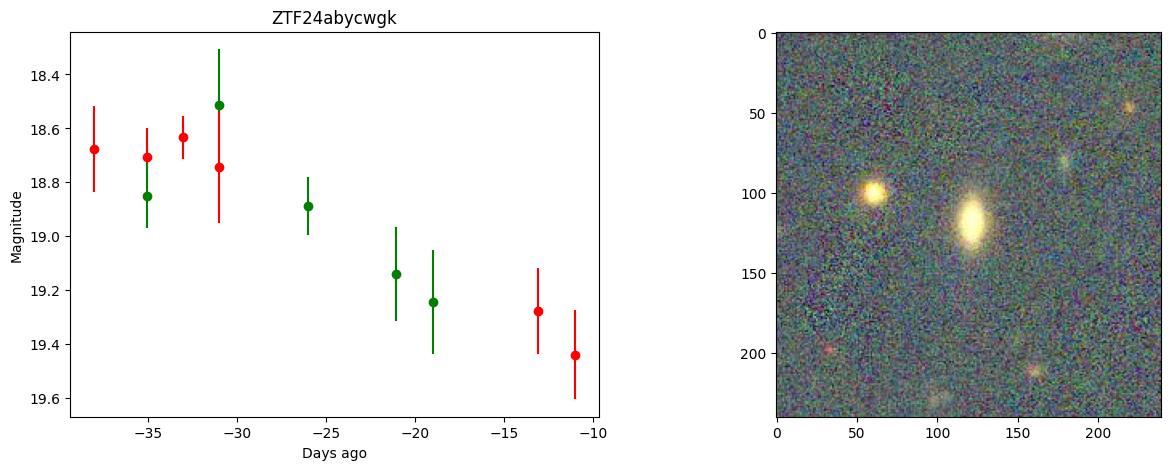

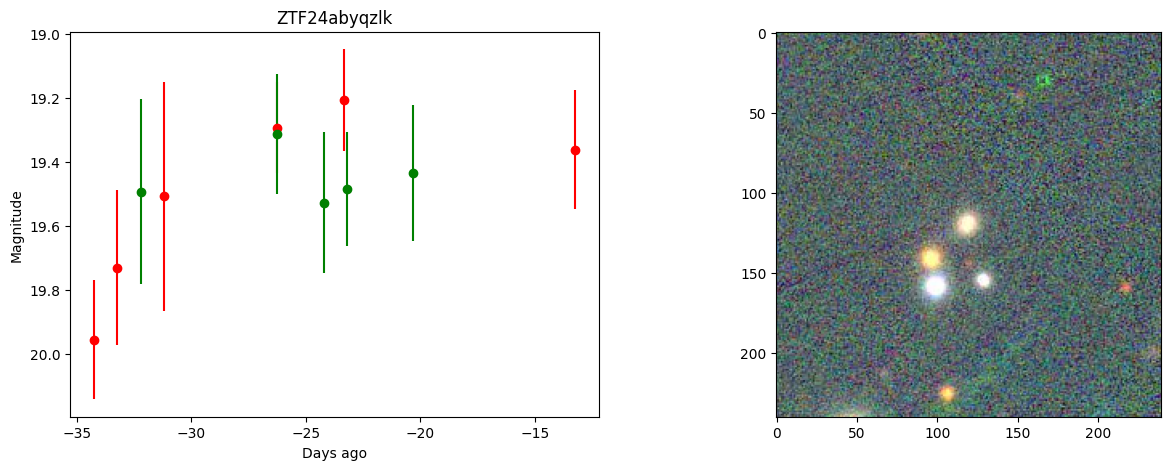

In [17]:
cols = {1:'g',2:'r'}

now = Time.now().jd

for obj in response:
    if len(obj['tns_name']) > 0:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        for i in lcsDict[obj['objectId']]['candidates']:
            if 'isdiffpos' in i:
                if i['isdiffpos']=='t':
                    plt.errorbar(i['jd']-now,i['magpsf'],i['sigmapsf'],fmt='o',color=cols[i['fid']])
        plt.gca().invert_yaxis()
        plt.ylabel('Magnitude')
        plt.xlabel('Days ago')
        plt.title(obj['objectId'])

            # show cutout
        if 'cutout' in obj:
            if os.path.exists(obj['cutout']):
                plt.subplot(122)
                file = obj['cutout']
                img = mpimg.imread(file)
                plt.imshow(img)